# Time-series Prediction

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t=1,2,\dots,\infty$ is given by

$$\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},$$

with $a_i \in \mathbb{R}$ for $i=1, \dots, p$ and $p$ the model lag. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear (NAR) variant is described as

$$\hat{z}_t = f(z_{t-1}, z_{t-2}, \dots, z_{t-p}).$$

The figure below visualizes this process.

<img src="https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/assets/nar.jpg" width="600">

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem $\hat{y}_t=f(x_t)$ with $y_t=z_t$ and $x_t=[z_{t-1}, z_{t-2}, \dots, z_{t-p}]$. When preparing the dataset and applying train/validation/test splits, it is important to prevent *data leakage* by respecting the temporal information flow. More precisely, a datapoint $z_t$ should not be part of two splits &mdash; either as input $x_t$ or target $y_t$ &mdash; and training (or validation) sets should not contain datapoints that occur after test datapoints.

In this notebook, we work on the time-series prediction problem using a multilayer perceptron (MLP) and a long short-term memory network (LSTM).

## Colab Setup
This part is only required when running this notebook "in the cloud" on [Google Colab](https://colab.research.google.com). When running it locally, skip this part and go to the next section.

In [2]:
# Load some auxiliary files from github.
# !wget https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz

## Setup
Import all the necessary modules used throughout this notebook and define some helper methods to work with timeseries data and visualize the results.

In [1]:
# Import the required modules for this notebook
from dataclasses import dataclass
from pathlib import Path
import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import TimeSeriesSplit

FIGURE_PATH = Path("../report/figures")

In [2]:
@dataclass
class Fold:
  train_idxs: np.ndarray
  val_idxs: np.ndarray

def prepare_timeseries(timeseries, lag, validation_size=0, validation_folds=0):
  # Generate train (and validation) sets for the given timeseries and lag
  data = scipy.linalg.hankel(timeseries[:-lag], timeseries[-lag-1:-1])
  targets = timeseries[lag:]
  if validation_size > 0 and validation_folds > 0:
    tss = TimeSeriesSplit(test_size=validation_size, gap=lag)
    tss.n_splits = validation_folds
    folds = [Fold(train_idxs, val_idxs) for (train_idxs, val_idxs) in tss.split(data)]
    return data, targets, folds
  return data, targets

def shift(window, values):
  # Append new values to the given window (dropping the oldest values)
  result = np.empty(window.shape)
  values = np.atleast_1d(values)
  s = values.shape[0]
  result[:-s] = window[s:]
  result[-s:] = values
  return result

def normalize(timeseries, params=None):
  # Apply z-score normalization to the given timeseries
  if params is None:
    params = (np.mean(timeseries), np.std(timeseries))
  mu, sigma = params
  normalized = (timeseries - mu) / sigma
  return normalized, params

def rescale(timeseries, params):
  # Rescale the normalized timeseries back to its original values
  mu, sigma = params
  rescaled = mu + timeseries * sigma
  return rescaled

In [75]:
def plot_history(history, title=None, filename=None):
  # Plot the train and validation loss curves
	fig, ax = plt.subplots(figsize=(10, 3))
	ax.semilogy(history['loss'], label='Train')
	if 'val_loss' in history:
		ax.semilogy(history['val_loss'], label='Validation')
	ax.legend()
	ax.set_xlabel('Epochs')
	ax.set_ylabel('Loss')
	if title is not None:
		plt.title(title)
	if filename is not None:
		plt.savefig(FIGURE_PATH / f"ex2_2_{filename}.pdf", bbox_inches='tight')
	plt.show()

def plot_timeseries(timeseries_dict, title=None, filename=None):
	# Plot the given timeseries
	fig, ax = plt.subplots(figsize=(10, 3))
	for label, (start, ts) in timeseries_dict.items():
		ax.plot(start + np.arange(len(ts)), ts, label=label)
	ax.legend()
	ax.set_xlabel('Timestep')
	ax.set_ylabel('Laser intensity')
	if title is not None:
		plt.title(title)
	if filename is not None:
		plt.savefig(FIGURE_PATH / f"ex2_2_{filename}.pdf", bbox_inches='tight')
	plt.show()

## Santa Fe Laser Dataset
The Santa Fe laser dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. The first $1000$ data points can be used for training and validation purposes. The aim is to predict the next $100$ points (it is forbidden to include these points in the training or validation sets!). Both datasets are stored in the `SantaFe.npz` file and are visualized below.

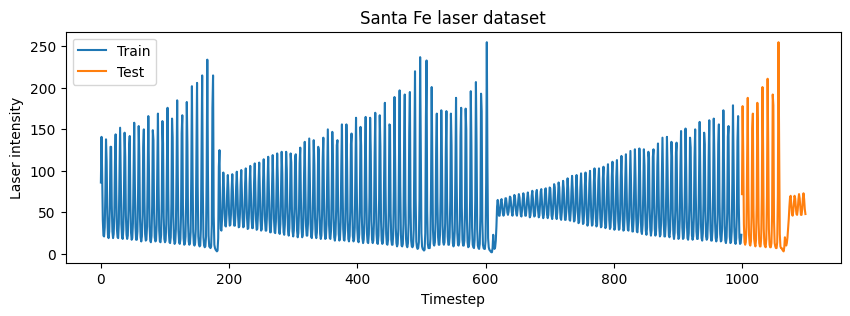

In [11]:
santafe = np.load('SantaFe.npz')
train_series = santafe['A']
test_series = santafe['Acont']
plot_timeseries({
    'Train': (0, train_series),
    'Test': (len(train_series), test_series)
}, 'Santa Fe laser dataset')

To train the various nonlinear autoregressive models, it will be useful to prepare the timeseries dataset beforehand. We start by normalizing the train and test sets.

In [12]:
normalized, params = normalize(santafe['A'])
normalized_test, _ = normalize(santafe['Acont'], params)

Next, the `prepare_timeseries` function is used to convert the timeseries into training data ($x_t$) and targets ($y_t$). Make sure you understand what the function does by trying it out on a small toy example.

In [13]:
timeseries = np.arange(10)  # Increase this number to create a larger time series
lag = 3  # Try different values for the lag
data, targets, folds = prepare_timeseries(timeseries, lag, validation_size=1, validation_folds=2)  # Examine the effect of the validation size and number of validation folds
print(f"Original timeseries: {timeseries}")
print(f"Data for lag {lag}: {data}")
print(f"Targets: {targets}")
for i, fold in enumerate(folds):
  print(f"Fold {i}:")
  print(f"  Train:     data={data[fold.train_idxs]}, targets={targets[fold.train_idxs]}")
  print(f"  Validate:  data={data[fold.val_idxs]}, targets={targets[fold.val_idxs]}")

Original timeseries: [0 1 2 3 4 5 6 7 8 9]
Data for lag 3: [[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]]
Targets: [3 4 5 6 7 8 9]
Fold 0:
  Train:     data=[[0 1 2]
 [1 2 3]], targets=[3 4]
  Validate:  data=[[5 6 7]], targets=[8]
Fold 1:
  Train:     data=[[0 1 2]
 [1 2 3]
 [2 3 4]], targets=[3 4 5]
  Validate:  data=[[6 7 8]], targets=[9]


Once you understand the dataset structure, apply it to the normalized Santa Fe timeseries. You can come back to these cells later to change the values of the lag or validation parameters.

In [172]:
# @title Parameters { run: "auto" }
lag = 80 # @param {type:"slider", min:1, max:100, step:1}
validation_size = 150 # @param {type:"slider", min:10, max:200, step:1}
validation_folds = 3 # @param {type:"slider", min:1, max:10, step:1}
# This is the hidden dimension of the MLP and LSTM networks trained later in this notebook
H = 100 # @param {type:"slider", min:10, max:100, step:1}

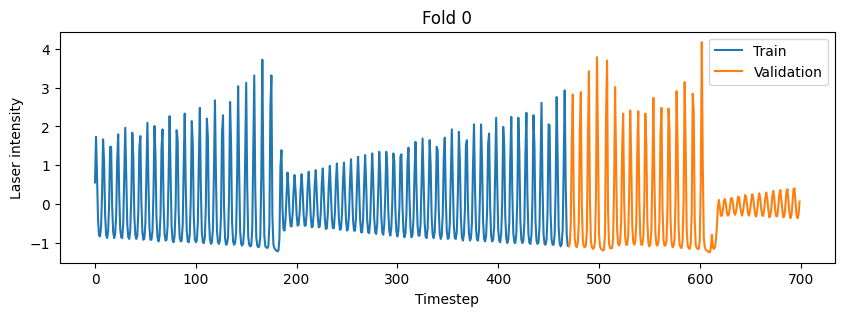

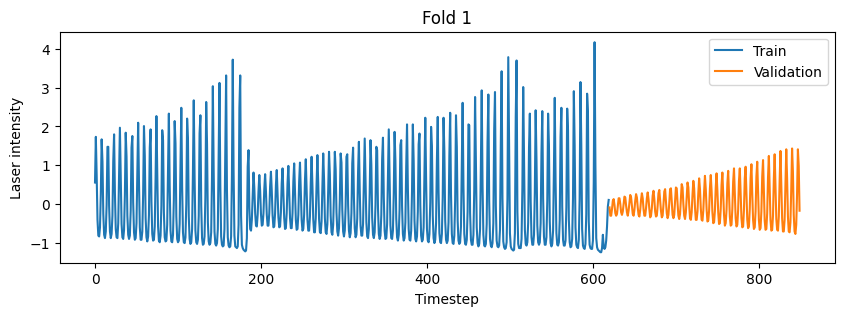

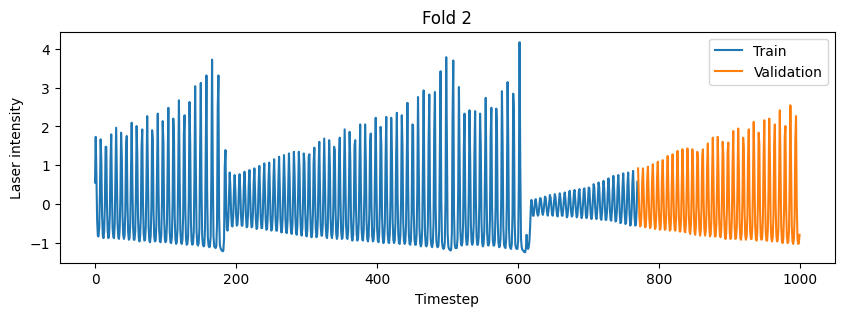

In [173]:
data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
  plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

## MLP
We now train a first nonlinear autoregressive (NAR) model on the training set and choose the hyperparameters based on the predictive performance on the validation sets. This first model is a multilayer perceptron (MLP) and training is done in feedforward mode using the prepared training set

$$\hat{z}_t = w^\top \tanh(V[z_{t-1}; z_{t-2}; \dots; z_{t-p}] + \beta).$$

In order to make predictions, the trained network is used in an iterative way as a recurrent network

$$\hat{z}_t = w^\top \tanh(V[\hat{z}_{t-1}; \hat{z}_{t-2}; \dots; \hat{z}_{t-p}] + \beta).$$

In [174]:
# Define the MLP network architecture
def MLP(input_dim, hidden_dim, output_dim, activation='tanh'):
  return keras.Sequential([
    keras.layers.Input(shape=[input_dim]),  # Expect input of shape (B, I) with B batch size, I input size
    keras.layers.Dense(units=hidden_dim, activation=activation),  # Output of shape (B, H) with H hidden feature size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, O) with O output size
  ])

Train the MLP on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

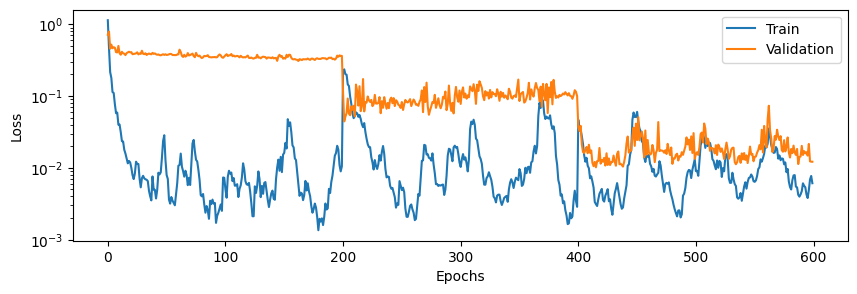

Final train loss: 0.012166990898549557


In [175]:
net = MLP(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
all_history = {
  "loss": [],
  "val_loss": []
}
for i, fold in enumerate(folds):
  history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                    validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                    epochs=200, verbose=0)
  all_history["loss"].extend(history.history["loss"])
  all_history["val_loss"].extend(history.history["val_loss"])

plot_history(all_history, filename="mlp_loss")
print(f"Final train loss: {all_history['val_loss'][-1]}")

Plot the train and validation loss curves.

### **Exercise 1**
Investigate the model performance with different lags and number of neurons. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

The MSE on the test set is: 277.304


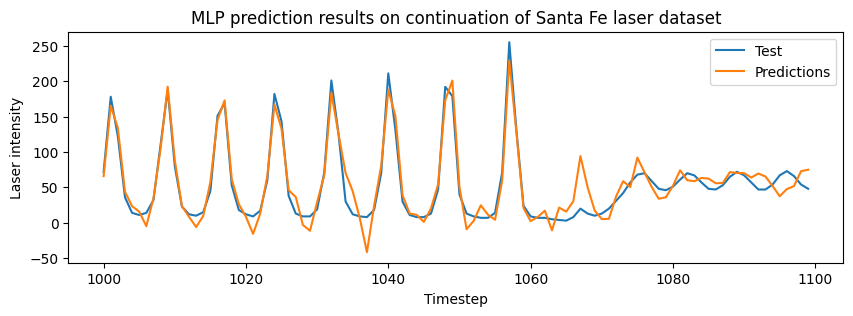

In [176]:
# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

## LSTM
We now train the second model, which is a Long Short Term Memory (LSTM) network. These are a special kind of RNN, capable of learning long-term dependencies. LSTMs contain information outside the normal flow of the recurrent network in a gated cell. Information can be stored in, written to, or read from a cell, much like data in a computer's memory. The cell makes decisions about what to store and when to allow reads, writes and erasures, via gates that open and close. Those gates act on the signals they receive, and similar to the neural network's nodes, they block or pass on information based on its strength and importance, which they filter with their own sets of weights. Those weights, like the weights that modulate input and hidden states, are adjusted via the recurrent network's learning process. That is, the cells learn when to allow data to enter, leave or be deleted through the iterative process of making guesses, backpropagating the error, and adjusting weights via gradient descent.

In [177]:
# Define the LSTM network structure
def LSTM(input_dim, hidden_dim, output_dim):
  return keras.Sequential([
    keras.layers.Input(shape=[None, input_dim], batch_size=1),  # LSTM layer expects input of shape (B, T, F) with B batch size, T timesteps, F feature size
    keras.layers.LSTM(units=hidden_dim, return_sequences=True, stateful=True),  # Output of shape (B, T, H) with H hidden state size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, T, O) with O output size
  ])

class LSTMCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()  # Make sure the LSTM's hidden state is reset after every epoch

Train the LSTM on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

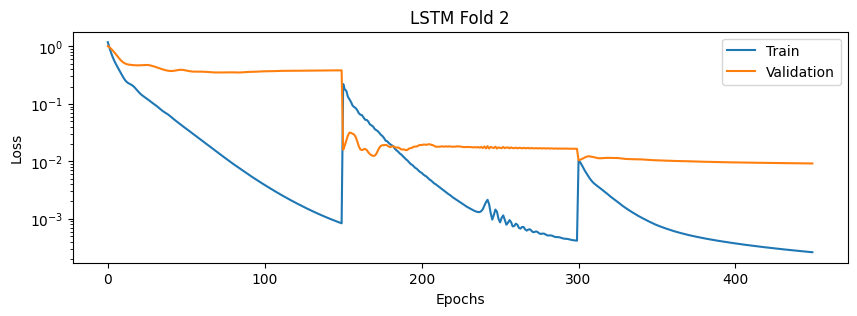

Last loss: 0.009175173006951809


In [178]:
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
all_history = {
  "loss": [],
  "val_loss": []
}
for i, fold in enumerate(folds):
  history = net.fit(
      data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
      validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
      epochs=150, callbacks=[LSTMCallback()], verbose=0)
  all_history["loss"].extend(history.history["loss"])
  all_history["val_loss"].extend(history.history["val_loss"])
  
plot_history(all_history, f"LSTM Fold {i}", "lstm_loss")
print("Last loss:", all_history["val_loss"][-1])

Plot the train and validation loss curves.

In [179]:
# plot_history(history, "LSTM training")

### **Exercise 2**
Investigate the model performance with different lags and number of hidden states. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

Compare the results of the recurrent MLP with the LSTM. Which model do you prefer and why?

The MSE on the test set is: 90.317


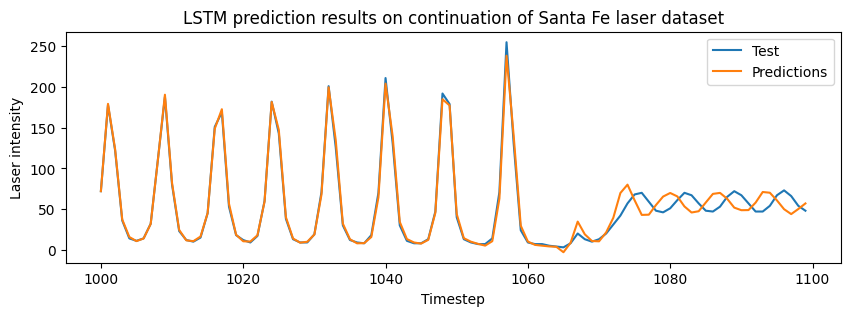

In [180]:
# LSTM Evaluation
net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)}, "LSTM prediction results on continuation of Santa Fe laser dataset")

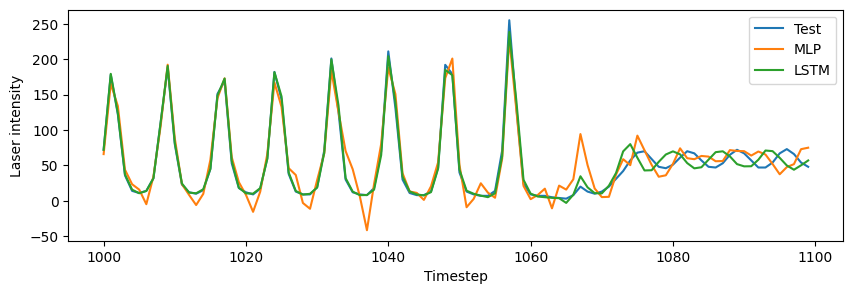

In [182]:
# Comparison of both models
# plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)}, "Prediction results on continuation of Santa Fe laser dataset", "comparison")
plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)}, filename="comparison")